Este proyecto buscará analizar la influencia de la localización geográfica (estado/ciudad) de los clientes en el comportamiento de compra dentro del e-commerce.

**Objetivos principales:**

Analizar el volumen de pedidos y ticket promedio según la región.

Identificar diferencias significativas en tiempos de entrega por estado/ciudad.

Detectar regiones con mayor nivel de retrasos o cancelaciones.

Explorar si el estado de origen del cliente influye en la probabilidad de compra o fidelidad.

In [1]:
#Cargamos las tablas y mostramos las primeras 5 filas de cada una
import pandas as pd
from IPython.display import display
# lista de tablas a cargar
tables = [
    "df_Customers.csv",
    "df_OrderItems.csv",
    "df_Orders.csv",
]
for table in tables:
    file_path = f"../data/01_raw/{table}"
    df = pd.read_csv(file_path)
    print(f"First 5 records of {table}:\n")
    display(df.head())
    print("\n")

First 5 records of df_Customers.csv:



,customer_id,customer_zip_code_prefix,customer_city,customer_state
0,hCT0x9JiGXBQ,58125,varzea paulista,SP
1,PxA7fv9spyhx,3112,armacao dos buzios,RJ
2,g3nXeJkGI0Qw,4119,jandira,SP
3,EOEsCQ6QlpIg,18212,uberlandia,MG
4,mVz5LO2Vd6cL,88868,ilhabela,SP




First 5 records of df_OrderItems.csv:



,order_id,product_id,seller_id,price,shipping_charges
0,Axfy13Hk4PIk,90K0C1fIyQUf,ZWM05J9LcBSF,223.51,84.65
1,v6px92oS8cLG,qejhpMGGVcsl,IjlpYfhUbRQs,170.80,23.79
2,Ulpf9skrhjfm,qUS5d2pEAyxJ,77p2EYxcM9MD,64.40,17.38
3,bwJVWupf2keN,639iGvMyv0De,jWzS0ayv9TGf,264.50,30.72
4,Dd0QnrMk9Cj5,1lycYGcsic2F,l1pYW6GBnPMr,779.90,30.66




First 5 records of df_Orders.csv:



,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_timestamp,order_estimated_delivery_date
0,Axfy13Hk4PIk,hCT0x9JiGXBQ,delivered,2017-10-22 18:57:54,2017-10-22 19:14:13,2017-10-26 22:19:52,2017-11-09
1,v6px92oS8cLG,PxA7fv9spyhx,delivered,2018-06-20 21:40:31,2018-06-20 22:20:20,2018-07-03 22:51:22,2018-07-24
2,Ulpf9skrhjfm,g3nXeJkGI0Qw,delivered,2018-02-16 16:19:31,2018-02-17 16:15:35,2018-02-27 01:29:50,2018-03-08
3,bwJVWupf2keN,EOEsCQ6QlpIg,delivered,2018-08-18 18:04:29,2018-08-18 18:15:16,2018-08-27 20:03:51,2018-09-19
4,Dd0QnrMk9Cj5,mVz5LO2Vd6cL,delivered,2017-12-22 16:44:04,2017-12-22 17:31:31,2018-01-05 19:22:49,2018-01-18


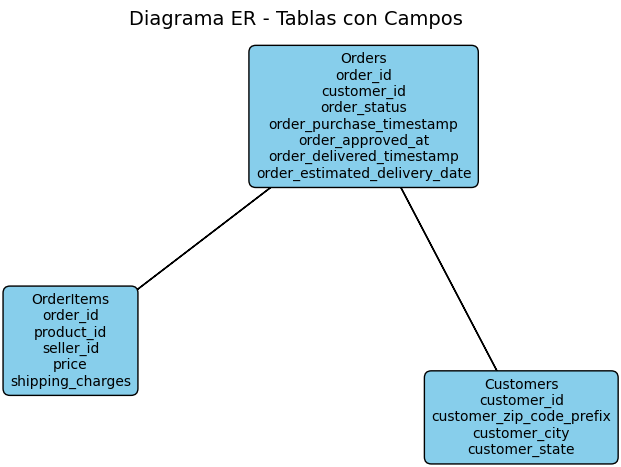

In [8]:
#mostrar diagrama ER simple con tablas y campos
import matplotlib.pyplot as plt
import networkx as nx

# Crear grafo dirigido
G = nx.DiGraph()

# Definir las tablas y sus campos
tables = {
    "Customers": ["customer_id", "customer_zip_code_prefix", "customer_city", "customer_state"],
    "Orders": ["order_id", "customer_id", "order_status", "order_purchase_timestamp",
                "order_approved_at", "order_delivered_timestamp", "order_estimated_delivery_date"],
    "OrderItems": ["order_id", "product_id", "seller_id", "price", "shipping_charges"]
}

# Agregar nodos
for table, fields in tables.items():
    label = table + "\n" + "\n".join(fields)
    G.add_node(table, label=label)

# Definir relaciones
relations = [
    ("Customers", "Orders"),
    ("Orders", "OrderItems")
]

# Agregar aristas
for start, end in relations:
    G.add_edge(start, end)

# Posiciones de nodos con más separación
pos = nx.spring_layout(G, seed=10, k=5)

# Dibujar nodos como cajas con campos
for node in G.nodes(data=True):
    x, y = pos[node[0]]
    # Bajar todos los nodos multiplicando y por un factor <1
    y = y * 0.8
    plt.text(x, y, node[1]['label'], fontsize=10, ha='center', va='center',
             bbox=dict(facecolor='#87CEEB', boxstyle='round,pad=0.5', edgecolor='black'))

# Dibujar aristas
for start, end in G.edges():
    x_start, y_start = pos[start]
    x_end, y_end = pos[end]
    # Ajustar también las aristas
    y_start *= 0.8
    y_end *= 0.8
    plt.arrow(x_start, y_start, x_end-x_start, y_end-y_start, 
              length_includes_head=True, head_width=0.05, color='black')

plt.axis('off')
plt.title("Diagrama ER - Tablas con Campos", fontsize=14, pad=55)
plt.subplots_adjust(top=0.8)  # Ajusta margen superior
plt.show()


---------------------------------------------------------------------------------------------------------------------------------------------------

**1) Evaluar la situación actual**

Datos disponibles:

customer_state y customer_city permiten segmentar clientes por ubicación.

order_status, order_delivered_timestamp, order_estimated_delivery_date permiten calcular retrasos por región.

price + shipping_charges permiten analizar ticket promedio y costo logístico por cliente.

Recursos: entorno Python, librerías de análisis y visualización, pipeline con Kedro.

Limitaciones:

No se cuenta con nacionalidad explícita, sino con ubicación (estado/ciudad) como proxy.

Posible sesgo si hay estados con muy pocos registros.

---------------------------------------------------------------------------------------------------------------------------------------------------

**3) Determinar objetivos de ML**

Clasificación: predecir si una orden de un cliente de cierto estado se entregará a tiempo o tarde.

Regresión: estimar el tiempo de entrega esperado según la localización del cliente.

Segmentación: agrupar clientes por patrones de compra y ubicación geográfica.

Predicción de demanda: estimar el volumen de compras por región para planificar logística.

---------------------------------------------------------------------------------------------------------------------------------------------------

**4) Elaborar plan del proyecto**

Comprensión del negocio: definir el enfoque en nacionalidad/localización.

Comprensión de los datos: explorar estados y ciudades con más clientes, analizar distribución.

Preparación de los datos: crear variables derivadas como retraso de entrega, ticket promedio por pedido, región de cliente.

Modelado: aplicar modelos de clasificación/regresión y clustering según los objetivos.

Evaluación: métricas como precisión de predicción de retraso, RMSE en tiempos de entrega, calidad de clusters geográficos.

Despliegue: mapa interactivo o dashboard con insights por estado/ciudad.